In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import re
import pandas as pd
import numpy as np
from scipy.special import gamma as GammaFunction
import pymc as pm
import arviz as az
import bambi as bmb
import pytensor.tensor as at
import matplotlib.pyplot as plt
import seaborn as sns
import dirichlet
import attila_utils
import mwm
#plt.rcParams['figure.dpi'] = 200

In [2]:
group2condition = {
    'A': 'WT',
    'B': '5xFAD',
    'C': '5xFAD + Amiloride',
}

## Training trials

In [41]:
fpath = '../../resources/QPS/5xFAD-mouse/amiloride-behavioral-data-cleaned.xlsx'
data_train = pd.read_excel(fpath, sheet_name='rawdata MWM day 1-4', header=[0,1], index_col=None)
data_train = pd.DataFrame(data_train.iloc[:, 4:].to_numpy(), columns=data_train.iloc[:, 4:].columns, index=pd.MultiIndex.from_frame(data_train.iloc[:, :4].xs('Covariates', axis=1, level=0)))
data_train = data_train.stack(level=1)
data_train = data_train.rename_axis(data_train.index.names[:-1] + ['Day'], axis=0)
data_train = pd.concat([data_train, data_train.index.to_frame()], axis=1)
data_train['Day'] = data_train.Day.str.replace('Day ', '').astype('float64')
#data_train['Day'] = data_train.Day.str.replace('Day ', '').astype(pd.Int64Dtype())
data_train['Condition'] = data_train.Group.apply(lambda x: group2condition[x])
data_train['Status'] = np.where(data_train['Latency (s)'] < 60, 'none', 'right') # censoring status
data_train = data_train.rename({'Latency (s)': 'Latency', 'Velocity (m/s)': 'Velocity', 'Thigmotaxis %': 'Thigmotaxis', 'Floating %': 'Floating', 'Distance (m)': 'Distance'}, axis=1)
data_train = data_train.rename_axis(['cohort', 'group', 'sex', 'irn', 'day'])
#data_train = pd.DataFrame(data_train.to_numpy(), index=list(range(data_train.shape[0])), columns=data_train.columns)
data_train.to_csv('../../results/2023-10-13-5xfad-maze/data_train-CO26990.csv')
data_train

Distance  Floating  Latency  Thigmotaxis  \
cohort group sex irn     day                                                
I      A     f   12913 A Day 1  10.841028  0.532622    60.08    66.311600   
                         Day 2   5.720320  7.641773    26.06    33.259165   
                         Day 3   3.967948  9.397345    22.70    16.170368   
                         Day 4   2.178462  6.630220    18.06     7.830300   
                 12915 A Day 1   8.892240  4.043839    47.62    70.582225   
...                                   ...       ...      ...          ...   
III    C     m   13958 A Day 4   3.717858  7.993118    20.74    32.184900   
                 13962 A Day 1  10.552825  1.930759    60.08    44.906775   
                         Day 2   9.089775  0.798936    60.08    18.708375   
                         Day 3   3.030865  7.857635    19.78    15.243320   
                         Day 4   6.122248  4.698587    33.14    25.740050   

                                Velocity Cohort Group Sex      IRN  Day  \
cohort group sex irn     day                                              
I      A     f   12913 A Day 1  0.180684      I     A   f  12913 A  1.0   
                         Day 2  0.202247      I     A   f  12913 A  2.0   
                         Day 3  0.166473      I     A   f  12913 A  3.0   
                         Day 4  0.120461      I     A   f  12913 A  4.0   
                 12915 A Day 1  0.182376      I     A   f  12915 A  1.0   
...                                  ...    ...   ...  ..      ...  ...   
III    C     m   13958 A Day 4  0.165693    III     C   m  13958 A  4.0   
                 13962 A Day 1  0.175880    III     C   m  13962 A  1.0   
                         Day 2  0.151496    III     C   m  13962 A  2.0   
                         Day 3  0.154832    III     C   m  13962 A  3.0   
                         Day 4  0.176833    III     C   m  13962 A  4.0   

                                        Condition Status  
cohort group sex irn     day                              
I      A     f   12913 A Day 1                 WT  right  
                         Day 2                 WT   none  
                         Day 3                 WT   none  
                         Day 4                 WT   none  
                 12915 A Day 1                 WT   none  
...                                           ...    ...  
III    C     m   13958 A Day 4  5xFAD + Amiloride   none  
                 13962 A Day 1  5xFAD + Amiloride  right  
                         Day 2  5xFAD + Amiloride  right  
                         Day 3  5xFAD + Amiloride   none  
                         Day 4  5xFAD + Amiloride   none  

[172 rows x 12 columns]

['named-figure/data-train-corr-plot-matrix.png',
 'named-figure/data-train-corr-plot-matrix.pdf']

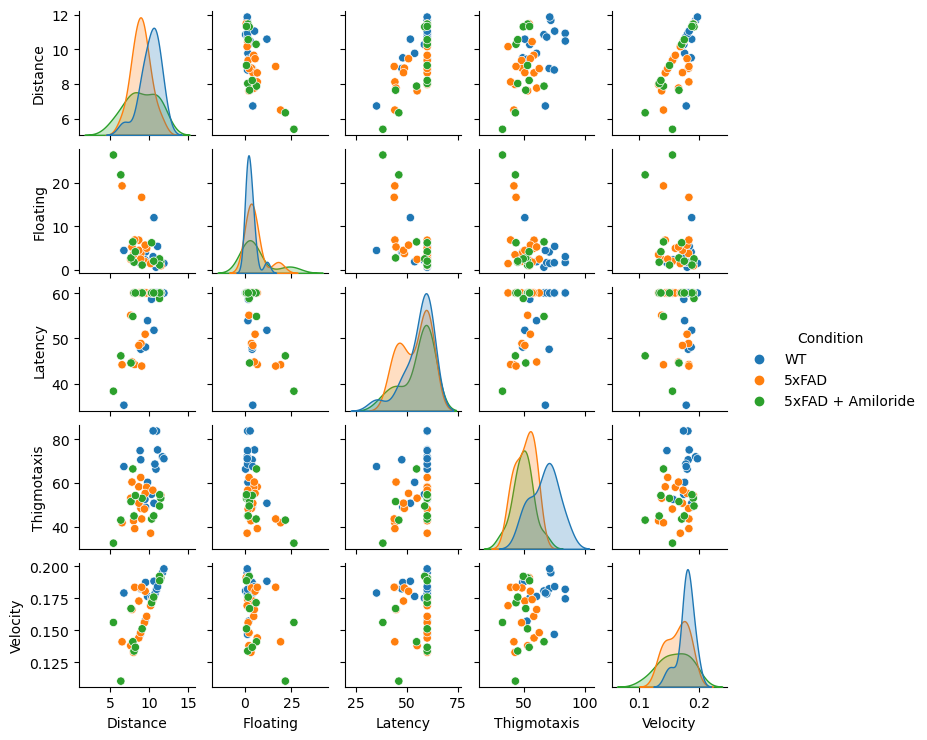

In [4]:
g = sns.pairplot(data_train.xs('Day 1', level='day', axis=0).drop('Day', axis=1), hue='Condition', height=1.5)
attila_utils.savefig(g, 'data-train-corr-plot-matrix')

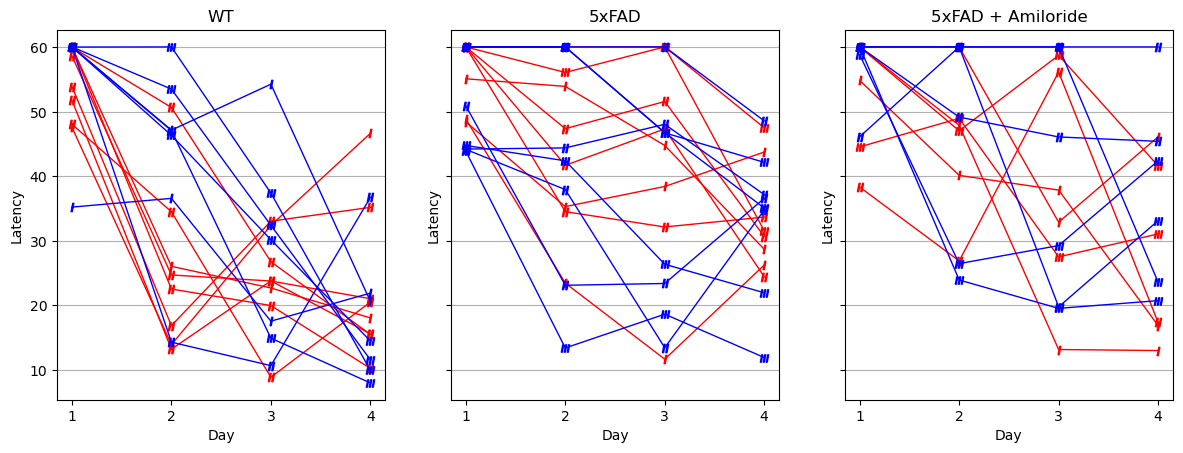

In [5]:
def data_plotter(yname='Latency', data_train=data_train):
    fig, ax = plt.subplots(1, len(data_train.Group.unique()), sharey=True, figsize=(3 * 4.8, 4.8))
    for group, axi in zip(data_train.Group.unique(), ax):
        axi.set_title(group2condition[group])
        axi.set_ylabel(yname)
        axi.set_xlabel('Day')
        axi.set_xticks(range(5))
        axi.set_xticklabels(range(5))
        axi.grid(axis='y')
        df1 = data_train.xs(group, level=1)
        for sex, color in zip(df1.Sex.unique(), ['red', 'blue']):
            df2 = df1.xs(sex, level=1)
            for irn in df2.IRN.unique():
                df3 = df2.xs(irn, level=1)
                for cohort in df3.Cohort.unique():
                    s = sex + cohort
                    y = df3[yname]
                    x = df3.Day
                    axi.plot(x, y, color=color, label=irn, marker='$' + cohort + '$', linewidth=1)
                pass
            pass
        #axi.legend()
    return((fig, ax))

fig, ax = data_plotter(yname='Latency')

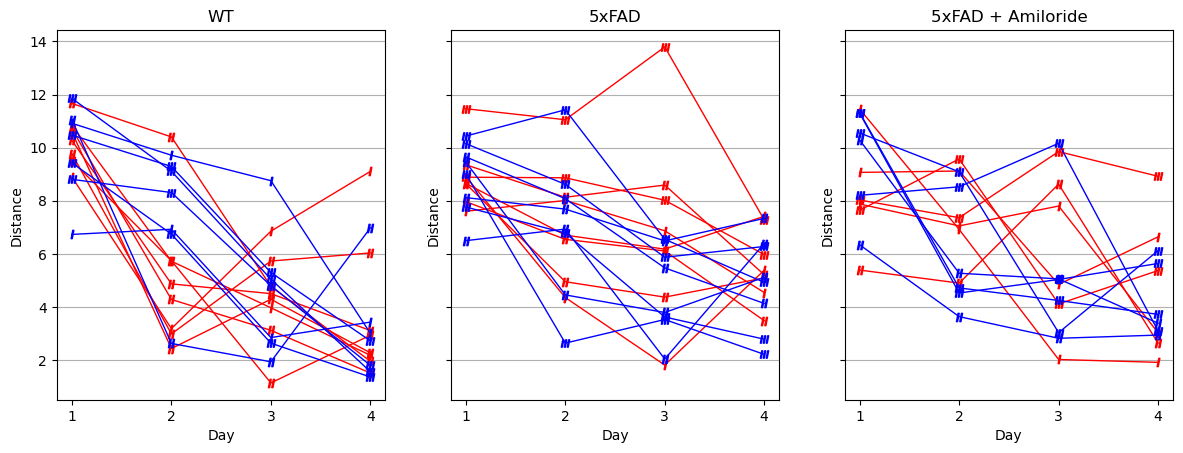

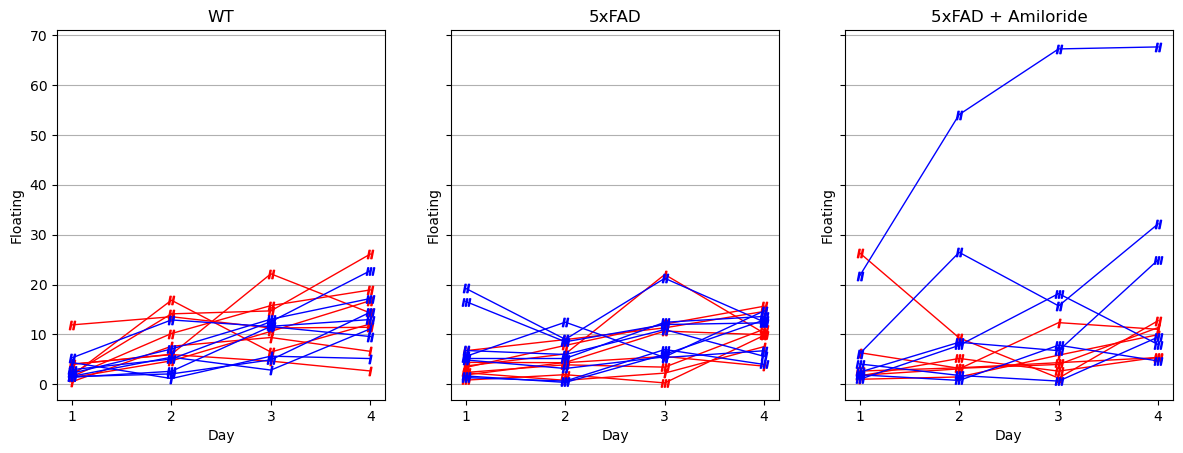

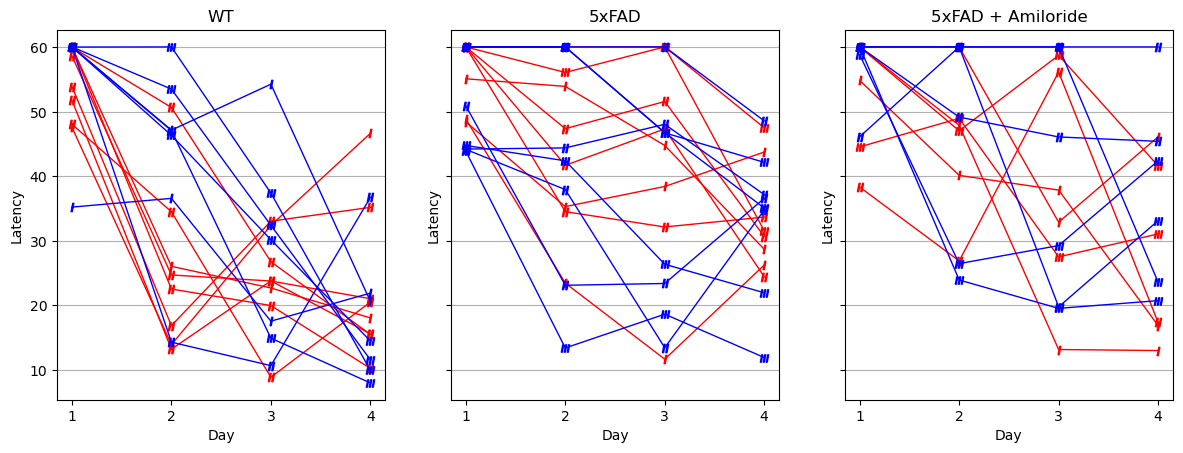

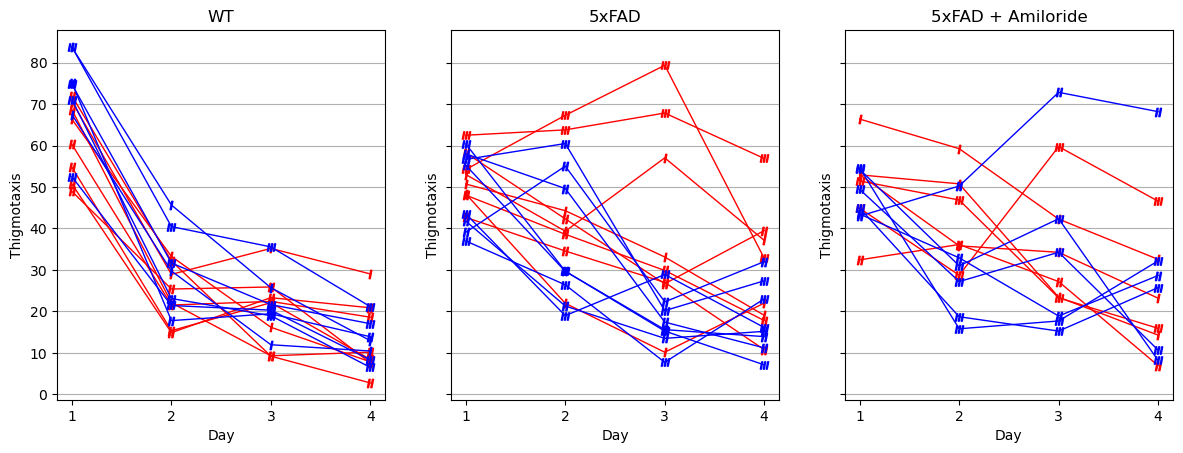

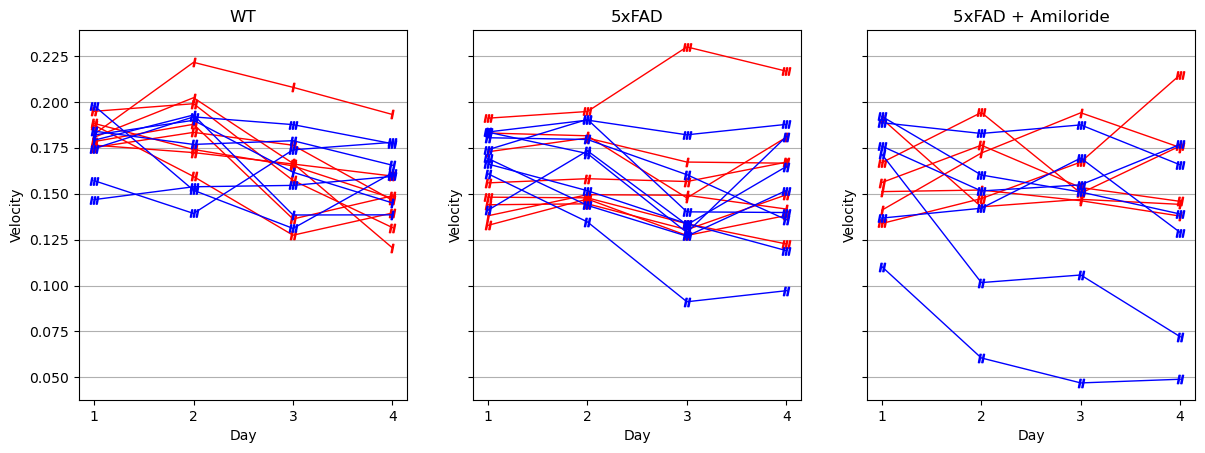

In [6]:
for yname in data_train.loc[:, :'Velocity'].columns:
    fig, ax = data_plotter(yname=yname)
    attila_utils.savefig(fig, 'training-' + re.sub('[ ()%/]+', '-', yname).strip('-'))

['named-figure/fraction-of-censored-latencies.png',
 'named-figure/fraction-of-censored-latencies.pdf']

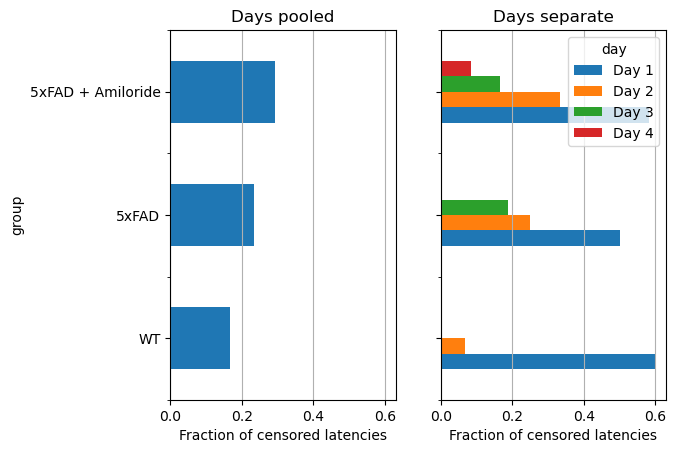

In [7]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
for title, axi, by in zip(['Days pooled', 'Days separate'], ax, ['group', ['group', 'day']]):
    s = (data_train['Latency'] >= 60).groupby(by).mean()
    d = s.unstack() if axi == ax[1] else s
    d.plot(kind='barh', ax=axi)
    #(data_train['Latency (s)'] >= 60).groupby(by).mean().unstack().plot(kind='barh', ax=axi)
    axi.set_yticklabels(group2condition.values())
    axi.set_xlabel('Fraction of censored latencies')
    axi.grid(axis='x')
    axi.set_title(title)

attila_utils.savefig(fig, 'fraction-of-censored-latencies')

## Modeling: Testing bambi

See `def test_censored_response()` [here](https://github.com/bambinos/bambi/blob/169564fe640818525049d7d946636266e4a7b968/tests/test_built_models.py#L1002-L1049)

The `bambi.load_data` function fails for reasons explained in [this page](https://stackoverflow.com/questions/71603314/ssl-error-unsafe-legacy-renegotiation-disabled).  To circumvent that, download datasets with browser onto a local disk and then use `pandas.read_csv` (see urls [here](https://app.codecov.io/gh/bambinos/bambi/pull/697/blob/bambi/data/datasets.py)):

In [8]:
fpath = '../../resources/testdata/bambi/kidney.csv'
kidney = pd.read_csv(fpath)
kidney['status'] = kidney.censored.apply(lambda x: 'none' if x else 'right')
kidney

,time,censored,patient,recur,age,sex,disease,status
0,8,0,1,1,28,male,other,right
1,23,0,2,1,48,female,GN,right
2,22,0,3,1,32,male,other,right
3,447,0,4,1,31,female,other,right
4,30,0,5,1,10,male,other,right
...,...,...,...,...,...,...,...,...
71,24,1,22,2,30,female,other,none
72,46,1,24,2,43,female,AN,none
73,5,1,34,2,45,female,GN,none
74,16,1,36,2,42,female,other,none


In [9]:
model = bmb.Model(
    'censored(time, status) ~ 1 + sex + age',
    kidney, 
    family='gamma',
    link='log',
    center_predictors=False
)
idata_kidney = model.fit()#init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(time, status)_alpha, Intercept, sex, age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [10]:
model_wb = bmb.Model(
    'censored(time, status) ~ 1 + sex + age',
    kidney, 
    family='weibull',
    link='log',
    center_predictors=False
)
idata_kidney_wb = model_wb.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(time, status)_alpha, Intercept, sex, age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


This fails with `TypeError: Encountered error in ELPD computation of compare.`

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'sex'}>, <Axes: title={'center': 'sex'}>],
       [<Axes: title={'center': 'age'}>, <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'censored(time, status)_alpha'}>,
        <Axes: title={'center': 'censored(time, status)_alpha'}>]],
      dtype=object)

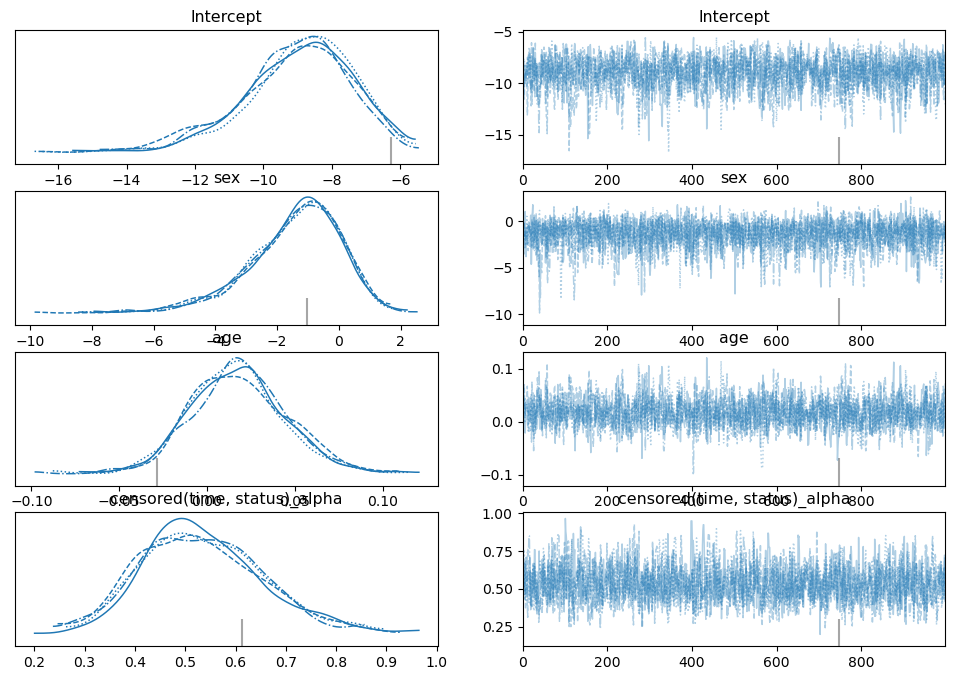

In [11]:
az.plot_trace(idata_kidney)

## Model selection for Fit MWM data

In [12]:
models_train = {}

models_train['M_2FE'] = bmb.Model(
    'censored(Latency, Status) ~ 1 + Day + Group',
    data_train, 
    family='weibull',
    link='log',
    center_predictors=False
)

models_train['M_4FE'] = bmb.Model(
    'censored(Latency, Status) ~ 1 + Day + Group + Sex + Velocity',
    data_train, 
    family='weibull',
    link='log',
    center_predictors=False
)

models_train['M_6FE'] = bmb.Model(
    'censored(Latency, Status) ~ 1 + Day + Group + Sex + Velocity + Thigmotaxis + Floating',
    data_train, 
    family='weibull',
    link='log',
    center_predictors=False
)

models_train['M_2FE_uncensored'] = bmb.Model(
    'Latency ~ 1 + Day + Group',
    data_train, 
    family='weibull',
    link='log',
    center_predictors=False
)

models_train['M_2FE_gamma'] = bmb.Model(
    'censored(Latency, Status) ~ 1 + Day + Group',
    data_train, 
    family='gamma',
    link='log',
    center_predictors=False
)

models_train['M_2FE_Rintcp|IRN'] = bmb.Model(
    'censored(Latency, Status) ~ 1 + Group + Day + (1 | IRN)',
    data_train, 
    family='weibull',
    link='log',
    center_predictors=False
)

models_train['M_2FE_Rday|IRN'] = bmb.Model(
    'censored(Latency, Status) ~ 1 + Group + Day + (0 + Day | IRN)',
    data_train, 
    family='weibull',
    link='log',
    center_predictors=False
)

models_train['M_2FE_Rintcp+Rday|IRN'] = bmb.Model(
    'censored(Latency, Status) ~ 1 + Group + Day + (1 + Day | IRN)',
    data_train, 
    family='weibull',
    link='log',
    center_predictors=False
)

models_train['M_2FE_Rintcp+Rday|Cohort/IRN'] = bmb.Model(
    'censored(Latency, Status) ~ 1 + Group + Day + (1 + Day | Cohort/IRN)',
    data_train, 
    family='weibull',
    link='log',
    center_predictors=False
)


models_train['M_4FE_Rday|IRN'] = bmb.Model(
    'censored(Latency, Status) ~ 1 + Day + Group + Sex + Velocity + (0 + Day | IRN)',
    data_train, 
    family='weibull',
    link='log',
    center_predictors=False
)

models_train['M_4FE_Rday|IRN_gamma'] = bmb.Model(
    'censored(Latency, Status) ~ 1 + Day + Group + Sex + Velocity + (0 + Day | IRN)',
    data_train, 
    family='gamma',
    link='log',
    center_predictors=False
)

models_train['M_4FE_Rintcp+Rday|Cohort/IRN'] = bmb.Model(
    'censored(Latency, Status) ~ 1 + Day + Group + Sex + Velocity + (1 + Day | Cohort/IRN)',
    data_train, 
    family='weibull',
    link='log',
    center_predictors=False
)

for m in models_train.values():
    m.build()

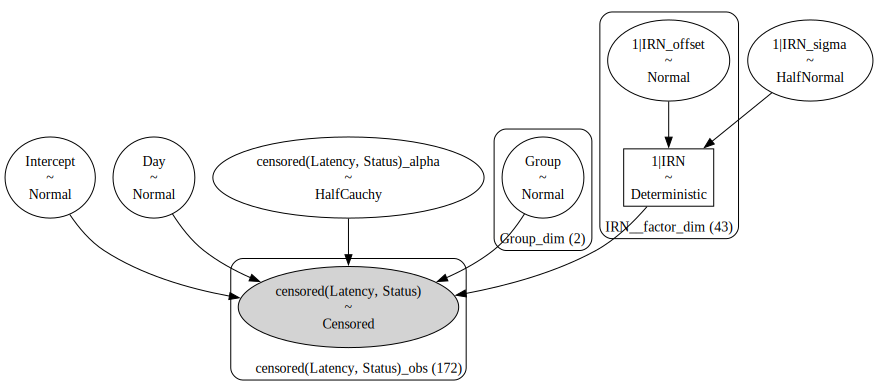

In [13]:
gv = models_train['M_2FE_Rintcp|IRN'].graph()
gv.save(filename='M_2FE_Rintcp_IRN', directory='named-figure/')
gv

In [14]:
def my_fit(model):
    try:
        mcmc_random_seed = [1947, 1949, 1976, 2021]
        val = model.fit(idata_kwargs={'log_likelihood': True}, random_seed=mcmc_random_seed)
    except(pm.SamplingError):
        val = None
    return(val)

idata_train = {k: my_fit(v) for k, v in models_train.items()}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Day, Group]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Day, Group, Sex, Velocity]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Day, Group, Sex, Velocity, Thigmotaxis, Floating]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Latency_alpha, Intercept, Day, Group]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Group, Day, Day|IRN_sigma, Day|IRN_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Group, Day, 1|IRN_sigma, 1|IRN_offset, Day|IRN_sigma, Day|IRN_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1006 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Day, Group, Sex, Velocity, Day|IRN_sigma, Day|IRN_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


In [15]:
idata_train

{'M_2FE': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'M_4FE': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'M_6FE': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'M_2FE_uncensored': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'M_2FE_gamma': None,
 'M_2FE_Rintcp|IRN': None,
 'M_2FE_Rday|IRN': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'M_2FE_Rintcp+Rday|IRN': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'M_2FE_Rintcp+Rday|Cohort/IRN': None,
 'M_4FE_Rday|IRN': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'M_4FE_Rday|IRN_gamma': None,
 'M_4FE_Rintcp+Rday|Cohort/IRN': None}

Repeat MCMC sampling for a few cases where `pymc.SamplingError` or other issue (judged from ELPD LOO) occurred.

In [16]:
k = 'M_2FE_gamma'
idata_train[k] = models_train[k].fit(idata_kwargs={'log_likelihood': True}, random_seed=[11947, 11949, 11976, 12021])

k = 'M_2FE_Rintcp|IRN'
idata_train[k] = models_train[k].fit(idata_kwargs={'log_likelihood': True}, random_seed=[11947, 11949, 11976, 12021])

k = 'M_2FE_Rintcp+Rday|IRN'
idata_train[k] = models_train[k].fit(idata_kwargs={'log_likelihood': True}, random_seed=[11947, 11949, 11976, 12021])

k = 'M_2FE_Rintcp+Rday|Cohort/IRN'
idata_train[k] = models_train[k].fit(idata_kwargs={'log_likelihood': True}, random_seed=[111947, 111949, 111976, 112021])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Day, Group]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Group, Day, 1|IRN_sigma, 1|IRN_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Group, Day, 1|IRN_sigma, 1|IRN_offset, Day|IRN_sigma, Day|IRN_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Group, Day, 1|Cohort_sigma, 1|Cohort_offset, 1|Cohort:IRN_sigma, 1|Cohort:IRN_offset, Day|Cohort_sigma, Day|Cohort_offset, Day|Cohort:IRN_sigma, Day|Cohort:IRN_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 138 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 234 divergences after tuning. Increase `target_accept` or reparameterize.


The following fits gave `pymc.SamplingError` after trying out 5-6 different random seed settings.

In [17]:
compare_train = az.compare({k: v for k, v in idata_train.items() if v is not None})
#compare_train = az.compare(idata_train)
#compare_train = compare_train.drop('M_2FE_Rintcp+Rday|IRN')
compare_train

/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jonesa7/opt/anaconda3/e

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
M_6FE,0,-541.772443,9.432977,0.000000,9.241727e-01,19.808180,0.000000,False,log
M_2FE_Rintcp+Rday|Cohort/IRN,1,-573.823172,33.481225,32.050728,7.582734e-02,19.009999,8.683193,True,log
M_2FE_Rintcp+Rday|IRN,2,-574.139853,30.726262,32.367409,3.314384e-12,18.791035,8.617242,True,log
M_2FE_Rintcp|IRN,3,-575.520853,27.029740,33.748410,2.373949e-12,18.912832,8.641468,True,log
M_2FE_Rday|IRN,4,-575.833671,26.487888,34.061227,2.127989e-12,18.403632,8.457532,True,log
M_4FE_Rday|IRN,5,-577.134379,27.961488,35.361935,2.176199e-12,18.775067,8.678601,True,log
M_2FE_gamma,6,-583.758891,4.549594,41.986447,1.407454e-12,18.189605,8.534237,False,log
M_4FE,7,-585.550577,7.842082,43.778134,1.797747e-12,18.595895,8.904507,False,log
M_2FE,8,-586.461771,5.268422,44.689328,1.663354e-12,18.072295,8.784434,False,log
M_2FE_uncensored,9,-697.557280,4.426625,155.784836,0.000000e+00,6.951455,21.724951,False,log


['named-figure/model-comparison-all.png',
 'named-figure/model-comparison-all.pdf']

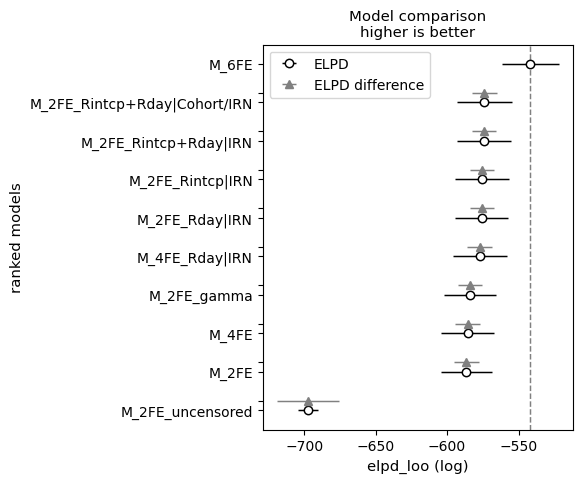

In [18]:
fig, ax = plt.subplots(figsize=(4, compare_train.shape[0] * 0.5))
az.plot_compare(compare_train, ax=ax, textsize=10)
ax.legend()
attila_utils.savefig(fig, 'model-comparison-all')

### Random effects

/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jonesa7/opt/anaconda3/e

['named-figure/model-comparison-randomfx.png',
 'named-figure/model-comparison-randomfx.pdf']

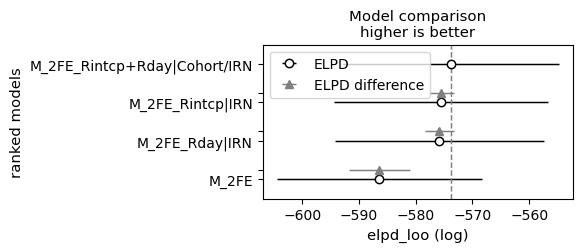

In [19]:
def compare_sel_mod(sel_mod, idata_train=idata_train, return_df=False):
    cmp = az.compare({k: v for k, v in idata_train.items() if k in sel_mod})
    if return_df:
        return(cmp)
    fig, ax = plt.subplots(figsize=(4, cmp.shape[0] * 0.5))
    g = az.plot_compare(cmp, ax=ax, textsize=10)
    ax.legend()
    return((fig, ax))

sel_mod = ['M_2FE', 'M_2FE_Rintcp|IRN', 'M_2FE_Rday|IRN', 'M_2FE_Rintcp+Rday|Cohort/IRN']
fig, ax = compare_sel_mod(sel_mod)
attila_utils.savefig(fig, 'model-comparison-randomfx')

### Error distribution: gamma vs Weibull

The gamma distribution yields better fit based on ELPD but the improvement (see `elpd_diff`) is only slightly greater than the dSE (see `dse`).  Therefore, given the difficulty to fit the gamma model, I will favor the Weibull model.

['named-figure/model-comparison-errordist.png',
 'named-figure/model-comparison-errordist.pdf']

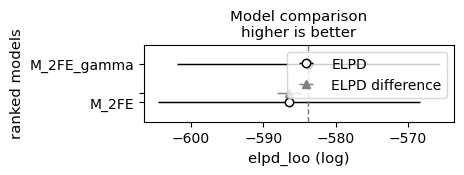

In [20]:
sel_mod = ['M_2FE', 'M_2FE_gamma']
fig, ax = compare_sel_mod(sel_mod)
attila_utils.savefig(fig, 'model-comparison-errordist')

### Additional covariates

['named-figure/model-comparison-covariates.png',
 'named-figure/model-comparison-covariates.pdf']

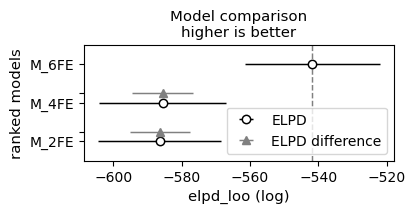

In [21]:
sel_mod = ['M_2FE', 'M_4FE', 'M_6FE']
fig, ax = compare_sel_mod(sel_mod)
attila_utils.savefig(fig, 'model-comparison-covariates')

## Fit diagnostics

['named-figure/mcmc-trace-M_2FE_Rday_IRN.png',
 'named-figure/mcmc-trace-M_2FE_Rday_IRN.pdf']

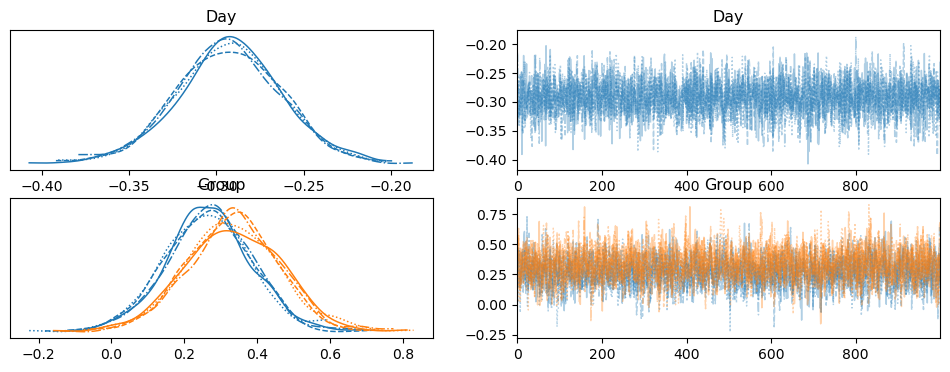

In [22]:
ax = az.plot_trace(idata_train['M_2FE_Rintcp|IRN'], var_names=['Day', 'Group'])
fig = ax[0, 0].figure
attila_utils.savefig(fig, 'mcmc-trace-M_2FE_Rday_IRN')

In [23]:
[k for k, v in idata_train.items() if k != 'M_2FE_Rintcp+Rday|IRN']

['M_2FE',
 'M_4FE',
 'M_6FE',
 'M_2FE_uncensored',
 'M_2FE_gamma',
 'M_2FE_Rintcp|IRN',
 'M_2FE_Rday|IRN',
 'M_2FE_Rintcp+Rday|Cohort/IRN',
 'M_4FE_Rday|IRN',
 'M_4FE_Rday|IRN_gamma',
 'M_4FE_Rintcp+Rday|Cohort/IRN']

In [24]:
def get_diagnostics(fun=az.ess, idata_train={k:v for k, v in idata_train.items() if k != 'M_2FE_Rintcp+Rday|IRN'}):
    s = pd.Series(idata_train).dropna()
    l = [s.apply(lambda x: fun(x, var_names=v).to_dict()['data_vars'][v]['data']).to_frame(v) for v in ['Intercept', 'Day']]
    l += [s.apply(lambda x: fun(x, var_names='Group').to_dict()['data_vars']['Group']['data'][i]).to_frame(n) for i, n in zip(range(2), ['Group B', 'Group C'])]
    df = pd.concat(l, axis=1)
    precision = np.int64(3 - np.round(np.log10(df.mean().mean())))
    val = df.style.format(precision=precision).background_gradient(axis=None, vmin=df.min().min(), vmax=df.max().max(), cmap='hot')
    return(val)

get_diagnostics(az.ess)

,Intercept,Day,Group B,Group C
M_2FE,2211,2147,2456,2402
M_4FE,1884,2381,2688,2592
M_6FE,1585,2226,2553,2932
M_2FE_uncensored,2307,2373,2665,2668
M_2FE_gamma,2115,2648,3103,2771
M_2FE_Rintcp|IRN,2005,3869,1855,1922
M_2FE_Rday|IRN,2917,2712,1850,2474
M_2FE_Rintcp+Rday|Cohort/IRN,279,291,221,296
M_4FE_Rday|IRN,1048,1862,1128,1525


In [25]:
get_diagnostics(az.rhat)

,Intercept,Day,Group B,Group C
M_2FE,1.001,1.002,1.001,1.000
M_4FE,1.002,1.002,1.001,1.001
M_6FE,1.002,1.002,1.001,1.001
M_2FE_uncensored,1.000,1.000,1.000,1.002
M_2FE_gamma,1.002,1.001,1.001,1.002
M_2FE_Rintcp|IRN,1.001,0.999,1.002,1.002
M_2FE_Rday|IRN,1.000,1.000,1.000,1.000
M_2FE_Rintcp+Rday|Cohort/IRN,1.015,1.016,1.016,1.014
M_4FE_Rday|IRN,1.004,1.000,1.007,1.001


In [26]:
get_diagnostics(az.mcse)

,Intercept,Day,Group B,Group C
M_2FE,0.00222,0.00074,0.00174,0.00193
M_4FE,0.00583,0.00071,0.00166,0.00190
M_6FE,0.00659,0.00072,0.00134,0.00142
M_2FE_uncensored,0.00139,0.00047,0.00117,0.00125
M_2FE_gamma,0.00623,0.00068,0.00160,0.00186
M_2FE_Rintcp|IRN,0.00251,0.00049,0.00279,0.00295
M_2FE_Rday|IRN,0.00183,0.00064,0.00257,0.00233
M_2FE_Rintcp+Rday|Cohort/IRN,0.02080,0.00587,0.00971,0.00837
M_4FE_Rday|IRN,0.00957,0.00081,0.00345,0.00311


['named-figure/model-comparison-94pct_CI.png',
 'named-figure/model-comparison-94pct_CI.pdf']

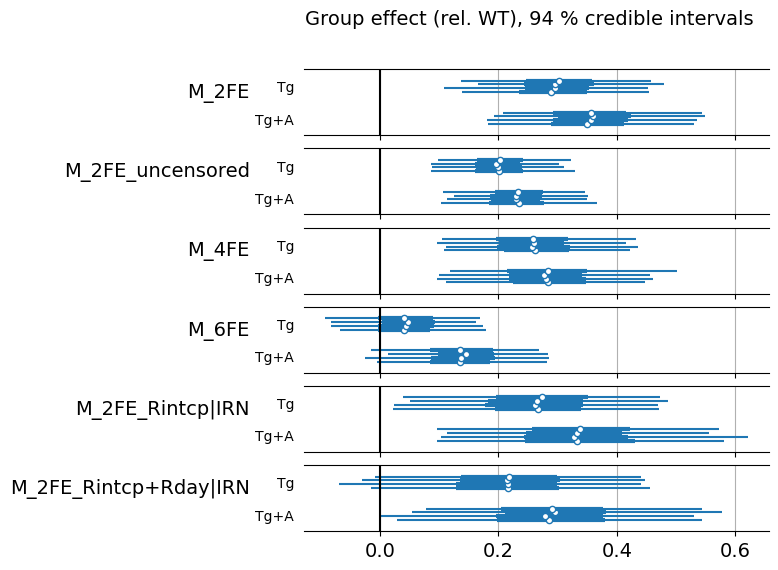

In [27]:
sel_models = ['M_2FE', 'M_2FE_uncensored', 'M_4FE', 'M_6FE', 'M_2FE_Rintcp|IRN', 'M_2FE_Rintcp+Rday|IRN']
fig, ax = plt.subplots(len(sel_models), 1, sharex=True, figsize=(6, 1 * len(sel_models)))
for m, axi in zip(sel_models, ax):
    az.plot_forest(idata_train[m], var_names=['Group'], ax=axi, ess=False)
    #axi.set_title(m, backgroundcolor= 'white')
    axi.set_title('')
    axi.set_ylabel(m, rotation='horizontal', horizontalalignment='right', fontsize=14)
    axi.set_yticklabels(['Tg+A', 'Tg'], fontsize=10)
    #axi.set_xticklabels(axi.get_xticklabels())
    axi.grid(axis='x')
    axi.axvline(0, color='black')

fig.suptitle('Group effect (rel. WT), 94 % credible intervals', fontsize=14)
    
attila_utils.savefig(fig, 'model-comparison-94pct_CI')

## Modeling directly with PyMC

The Weibull distribution has two parameters: $\alpha$ (shape) and $\beta$ (scale); see this [PyMC doc](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.Weibull.html#pymc.Weibull).  It's mean $\mu$ is:
\begin{equation}
\mu = \beta \Gamma \left( 1 + \frac{1}{\alpha} \right) \; 
\Rightarrow \;
\beta = \frac{\mu}{\Gamma \left( 1 + \frac{1}{\alpha} \right)}
\end{equation}

In [28]:
mwm.get_Weibull_beta(10)

True_div.0

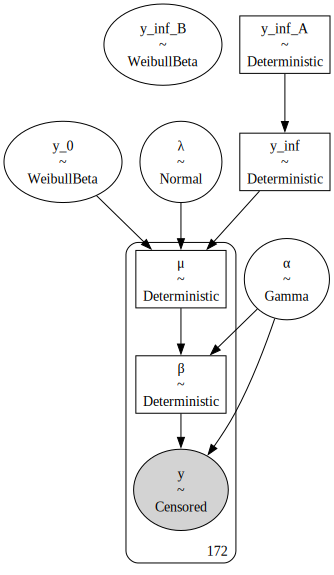

In [29]:
y_obs = data_train.Latency.values
x_obs = data_train.Day.values
gv = pm.model_to_graphviz(mwm.model_A(y_obs, x_obs, return_model=True, y_inf_A_val=0, censored=True))
gv

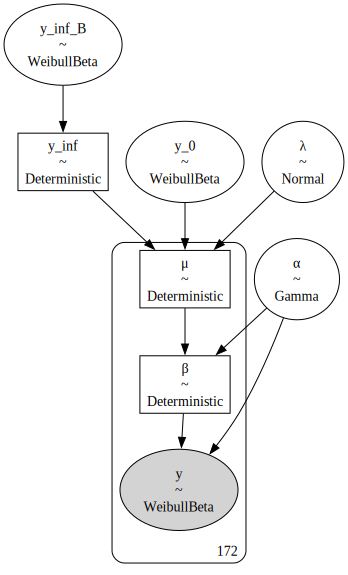

In [30]:
gv = pm.model_to_graphviz(mwm.model_A(y_obs, x_obs, return_model=True, y_inf_A_val=None, censored=False))
gv

In [31]:
d = {'y_inf random': None, 'y_inf = 0': 0, 'y_inf = 10': 10}
#d = {'y_inf random': [None, True], 'y_inf = 0': [0, True], 'y_inf = 10': [10, True], 'y_inf = 10': [10, True]}
idata_1 = {k: mwm.model_A(y_obs, x_obs, return_model=False, y_inf_A_val=v, censored=False) for k, v in d.items()}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_0, y_inf_B, λ, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_0, y_inf_B, λ, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_0, y_inf_B, λ, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


In [32]:
az.compare(idata_1)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
y_inf random,0,-703.133638,2.547686,0.000000,0.637832,6.883183,0.000000,False,log
y_inf = 0,1,-703.144920,2.594337,0.011282,0.362168,6.895963,0.285479,False,log
y_inf = 10,2,-703.165876,2.591466,0.032238,0.000000,6.887549,0.119409,False,log


array([[<Axes: title={'center': 'λ'}>, <Axes: title={'center': 'λ'}>],
       [<Axes: title={'center': 'y_0'}>, <Axes: title={'center': 'y_0'}>],
       [<Axes: title={'center': 'y_inf_B'}>,
        <Axes: title={'center': 'y_inf_B'}>],
       [<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'y_inf'}>,
        <Axes: title={'center': 'y_inf'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>]],
      dtype=object)

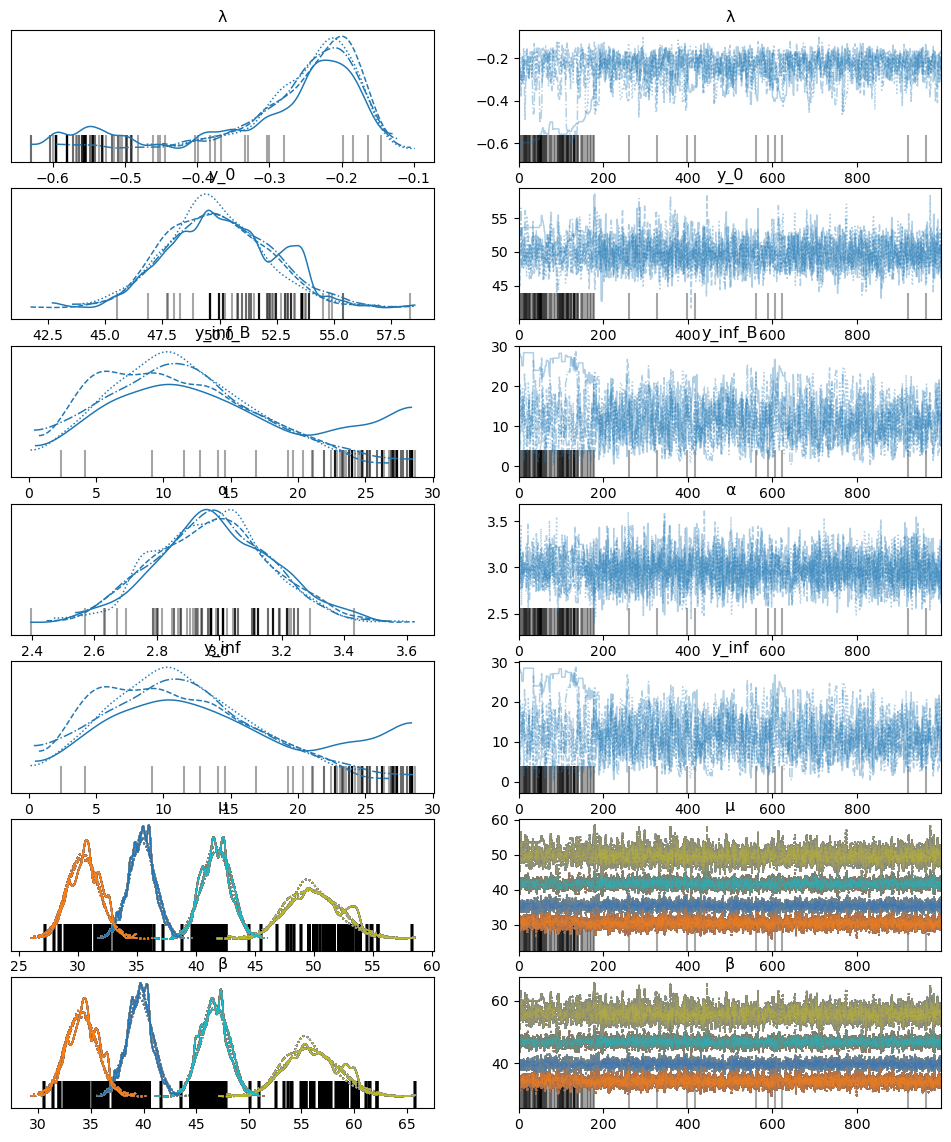

In [33]:
az.plot_trace(idata_1['y_inf random'])

array([[<Axes: title={'center': 'λ'}>, <Axes: title={'center': 'λ'}>],
       [<Axes: title={'center': 'y_0'}>, <Axes: title={'center': 'y_0'}>],
       [<Axes: title={'center': 'y_inf_B'}>,
        <Axes: title={'center': 'y_inf_B'}>],
       [<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'y_inf_A'}>,
        <Axes: title={'center': 'y_inf_A'}>],
       [<Axes: title={'center': 'y_inf'}>,
        <Axes: title={'center': 'y_inf'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>]],
      dtype=object)

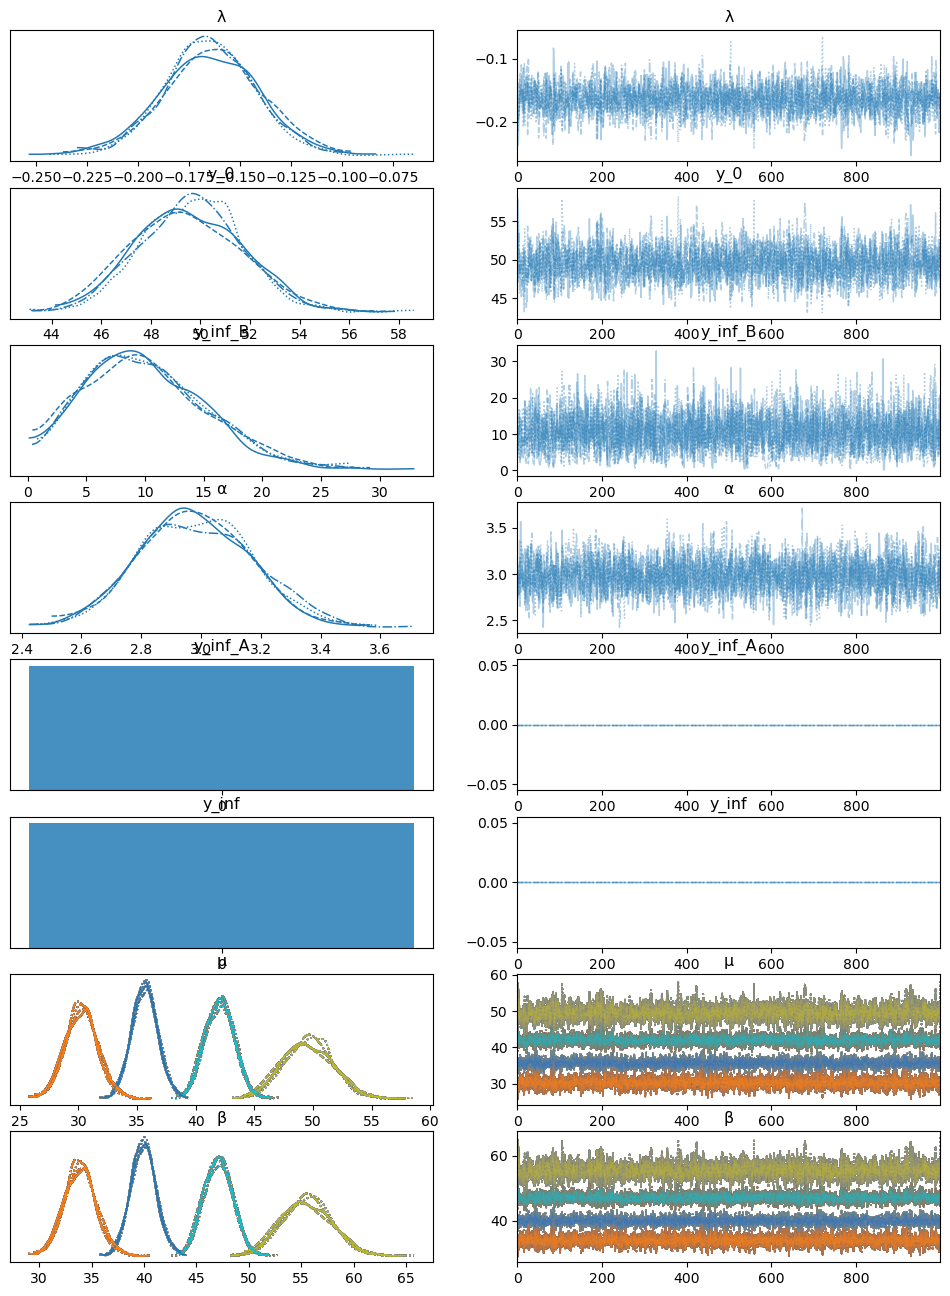

In [34]:
az.plot_trace(idata_1['y_inf = 0'])

In [40]:
%connect_info

{
  "shell_port": 54621,
  "iopub_port": 54622,
  "stdin_port": 54623,
  "control_port": 54625,
  "hb_port": 54624,
  "ip": "127.0.0.1",
  "key": "40ddfdfc-f66c97ecd282cc3572a2a946",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-21e0eb21-e2b2-410a-9ad3-0ed382bbcd83.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
